## 基于公募基金重仓数据的因子策略

$Yifan \space Zhang$ 

$2020.11$

### 背景及思路：
+ 公募基金在每个季度结束后的15个交易日内披露前十大重仓股数据，包括持股代码、持仓市值、占基金股票投资比例等信息
+ 通过公募基金过去一段时间的净值表现、产品规模等信息可以对基金进行筛选构建优选基金池
+ 基于优选基金池的季度重仓数据构造因子对股票进行打分，选取得分靠前的一定数量股票持有

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import *
# from WindPy import w
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

plt.style.use('seaborn')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体

### Step 1：基金数据获取

需要获取的数据包括：
+ 普通股票型基金、混合型基金和灵活配置型基金的基本信息，包括基金代码、基金公司、基金类型等
+ 基金的每日净值
+ 基金的季度管理规模和持仓

In [3]:
start_date = '20070101'
end_date = '20200930'
update = False

In [4]:
if update:
    w.start()

In [5]:
# 数据获取函数

# 基金基础信息 从Wind终端下载原始表格
def GetFundsBasic():
        # 基金基础信息，包含Wind基金二级分类中的普通股票型、偏股混合型和灵活配置型基金
        funds_basic = pd.read_csv('funds_basic.csv', encoding='gbk')
        
        # 将C类基金去掉，基金规模采用A+C之和。选取至少成立1年的基金
        year_before_end = (pd.Timestamp(end_date)-pd.DateOffset(years=1)).strftime('%Y%m%d')
        funds_basic = funds_basic[(~funds_basic['name'].str.contains('C')) & (funds_basic['issue_date'] <= year_before_end)]
        
        return funds_basic


# 基金日度单位净值 调用Wind接口更新数据 
def GetFundsNav(fund_codes, start_date, end_date, update=False):
    funds_nav = pd.read_csv('funds_nav.csv', parse_dates=['date'])
    funds_nav = funds_nav[funds_nav['code'].isin(fund_codes)]
    funds_nav = funds_nav[(funds_nav['date'] >= start_date) & (funds_nav['date'] <= end_date)]
    load_end_date = np.max(funds_nav['date']).strftime('%Y%m%d')
    
    # 若需要更新数据
    if (end_date > load_end_date) & update & w.isconnected():
        start_date = (pd.Timestamp(load_end_date) + pd.DateOffset(days=1)).strftime('%Y%m%d')
        print('updating date from {} to {}'.format(start_date, end_date))
        
        # 限制单次获取数据量
        limit = 10
        new_funds_nav = []

        for i in trange(len(fund_codes)//10):
            if i < len(fund_codes)//10 - 1:
                codes = fund_codes[i*10: i*10+limit]
            else:
                codes = fund_codes[i*10:]
            
            _, nav = w.wsd(codes, "NAV_adj", start_date, end_date, usedf=True)
            new_funds_nav.append(nav)

        new_funds_nav = pd.concat(new_funds_nav, axis=1)
        new_funds_nav = new_funds_nav.stack().rename('nav').reset_index().rename(columns={'level_0':'date','level_1':'code'})
        funds_nav = pd.concat([funds_nav, new_funds_nav]).reset_index(drop=True)
        funds_nav = funds_nav.sort_values(by='date')
        funds_nav['date'] = funds_nav['date'].map(lambda x: x.strftime('%Y%m%d'))
        funds_nav.to_csv('funds_nav.csv', index=False)
        funds_nav = pd.read_csv('funds_nav.csv', parse_dates=['date'])
        
    return funds_nav


# 基金季度规模 调用Wind接口更新数据 
def GetFundsAsset(fund_codes, start_date, end_date, update=False):
    funds_asset = pd.read_csv('funds_asset.csv', parse_dates=['date'])
    funds_asset = funds_asset.dropna().reset_index(drop=True)
    funds_asset = funds_asset[funds_asset['code'].isin(fund_codes)]
    funds_asset = funds_asset[(funds_asset['date'] >= start_date) & (funds_asset['date'] <= end_date)]
    load_end_date = np.max(funds_asset['date']).strftime('%Y%m%d')
    
    # 若需要更新数据
    if (end_date > load_end_date) & update & w.isconnected():
        start_date = load_end_date
        print('updating from {} to {}'.format(start_date, end_date))
        _, new_funds_asset = w.wsd(fund_codes, "netasset_total", start_date, end_date, 'Period=Q;Days=Alldays',usedf=True)
        new_funds_asset = new_funds_asset.stack().rename('asset').reset_index().rename(columns={'level_0':'date','level_1':'code'})
        funds_asset = pd.concat([funds_asset, new_funds_asset]).reset_index(drop=True)
        funds_asset.drop_duplicates(subset=['date', 'code'], inplace=True)
        funds_asset = funds_asset.sort_values(by='date')
        funds_asset['date'] = funds_asset['date'].map(lambda x: x.strftime('%Y%m%d'))
        funds_asset.to_csv('funds_asset.csv', index=False)
        funds_asset = pd.read_csv('funds_asset.csv', parse_dates=['date'])
    
    return funds_asset
        
# 获取单一基金前X名重仓股的季度信息 调用Wind接口下载数据 
# 由于数据量较多 本研究采用从Wind终端下载excel再整合的形式获取持仓数据    
def GetFundPortfolio(fund_code, start_date, end_date, top=10):
    fund_portfolio = []
    
    # 遍历获取单一基金权重第X名的季度持仓信息
    for i in range(top):
        order = i + 1
        _, data = w.wsd(fund_code, 
                                  " fund_stm_issuingdate_qty, prt_topstockname, prt_topstockcode, prt_topproportiontofloating, prt_heavilyheldstocktostock", 
                                  start_date, end_date, 'Period=Q;Order={};Days=Alldays'.format(order),usedf=True)
        data.rename(columns={'FUND_STM_ISSUINGDATE_QTY':'rpt_date',
                                      'PRT_TOPSTOCKNAME':'stock_name',
                                      'PRT_TOPSTOCKCODE':'stock_code',
                                      'PRT_TOPPROPORTIONTOFLOATING':'floating_pct',
                                      'PRT_HEAVILYHELDSTOCKTOSTOCK':'holidng_pct'}, inplace=True)
        data['ranking'] = order
        data['code'] = fund_code
        fund_portfolio.append(data)
    fund_portfolio = pd.concat(fund_portfolio).dropna().reset_index().rename(columns={'index':'date'}) # 合并数据
    fund_portfolio = fund_portfolio.sort_values(by=['date','ranking']).reset_index(drop=True)          
    fund_portfolio = fund_portfolio[['code']+fund_portfolio.columns.tolist()[:-1]]                     
    return fund_portfolio

def GetFundsPortfolio(fund_basic, start_date, end_date):
    funds_info = fund_basic.set_index('code')['issue_date'].to_dict()
    funds_portfolio = []
    for fund_code, issue_date in tqdm(funds_info.items()):
        fund_portfolio = GetFundPortfolio(fund_code, max(start_date, issue_date), end_date)
        funds_portfolio.append(fund_portfolio)
    funds_portfolio = pd.concat(funds_portfolio).reset_index(drop=True)
    return funds_portfolio

In [6]:
# 基金基础信息，包含Wind基金二级分类中的普通股票型、偏股混合型和灵活配置型基金
funds_basic = GetFundsBasic()
fund_codes = funds_basic['code'].unique().tolist()
funds_basic.head()

,code,name,issue_date,type,management
0,000001.OF,华夏成长,2001-11-28,偏股混合型基金,华夏基金管理有限公司
1,000006.OF,西部利得量化成长,2019-02-15,偏股混合型基金,西部利得基金管理有限公司
2,000011.OF,华夏大盘精选,2004-07-06,偏股混合型基金,华夏基金管理有限公司
3,000017.OF,财通可持续发展主题,2013-02-25,偏股混合型基金,财通基金管理有限公司
4,000020.OF,景顺长城品质投资,2013-02-25,偏股混合型基金,景顺长城基金管理有限公司


In [8]:
# 基金每日净值和季度规模
funds_nav = GetFundsNav(fund_codes, start_date, end_date, update=update)
funds_asset = GetFundsAsset(fund_codes, start_date, end_date, update=update)

In [9]:
funds_asset.head(3)

,date,code,asset
0,2007-03-31,000001.OF,1.047223e+10
1,2007-03-31,121005.OF,1.577857e+09
2,2007-03-31,121003.OF,1.867102e+09


In [10]:
funds_nav.head(3)

,date,code,nav
0,2007-01-04,000001.OF,2.350666
1,2007-01-04,310328.OF,2.250894
2,2007-01-04,310358.OF,1.064700


### Step 2：基金数据统计

In [11]:
# 计算基金季度收益
def CalRet(series):
    return np.nanprod(series/series.shift(1))-1

q_ret = funds_nav.groupby([pd.Grouper(key='date', freq='Q'), 'code'])['nav'].apply(CalRet)
q_ret.name = 'q_return'

In [12]:
# 获取下一季度的收益
q_next_ret = q_ret.groupby('code').apply(lambda x: x.shift(-1))
q_next_ret.name = 'q_next_return'
q_stat = pd.concat([q_ret, q_next_ret], axis=1)

In [13]:
# 基金日度收益pivot
pivot_nav = funds_nav.pivot_table(index='date', columns='code')
pivot_nav.columns = pivot_nav.columns.levels[1]
pivot_nav.tail(3)

code,000001.OF,000006.OF,000011.OF,000017.OF,000020.OF,000021.OF,000029.OF,000030.OF,000031.OF,000039.OF,...,710002.OF,720001.OF,730001.OF,730002.OF,740001.OF,750001.OF,750005.OF,762001.OF,770001.OF,910007.OF
date,,,,,,,,,,,,,,,,,,,,,
2020-09-28,8.274833,1.8039,34.283963,4.394945,3.978240,5.052651,3.222770,2.698448,3.010,2.9549,...,3.467648,4.347787,2.365913,1.913684,1.927969,3.191565,1.949243,4.185450,2.607659,4.4664
2020-09-29,8.292770,1.8223,34.416276,4.463348,4.018501,5.114369,3.241278,2.705668,3.056,2.9893,...,3.504866,4.403342,2.391545,1.908613,1.934516,3.204447,1.947811,4.225831,2.635469,4.4883
2020-09-30,8.286791,1.8198,34.451683,4.488050,4.018501,5.128770,3.243591,2.707519,3.093,2.9911,...,3.509946,4.441700,2.394788,1.909501,1.949245,3.193175,1.948384,4.255388,2.645230,4.4974


In [14]:
# 计算基金年化收益，年化波动率，夏普率和最大回撤
def GetYearStat(series):
    date = series.index.get_level_values('date')[0]
    year_before = date - pd.DateOffset(years=1)
    codes = list(series.index.get_level_values('code'))
    stat = pd.DataFrame(columns=['y_return', 'y_vol', 'y_sharpe', 'y_maxdrawdown'], index=codes)
    stat.index.name = 'code'
    nav = pivot_nav.query("date >'{}' & date<='{}'".format(year_before, date)).dropna(axis=1) # 要有完整一年的数据
    
    stat['y_return'] = np.prod(1 + nav.pct_change())**(252/len(nav)) - 1
    stat['y_vol'] = np.std(nav.pct_change()) * np.sqrt(252)
    stat['y_sharpe'] = (stat['y_return'] - 0.03) / stat['y_vol']
    stat['y_maxdrawdown'] = np.min(nav/nav.cummax()-1)
    return stat

y_stat = q_stat.groupby('date').apply(GetYearStat)

In [15]:
# 数据汇总
funds_stat = pd.concat([q_stat, y_stat], axis=1)
funds_stat = pd.merge(left=funds_stat, right=funds_asset, on=['date', 'code'], how='left')
funds_stat = pd.merge(left = funds_stat, right= funds_basic[['code', 'type']], on = 'code', how='left')
funds_stat.dropna(subset=['q_return', 'y_return', 'y_vol', 'y_sharpe', 'y_maxdrawdown', 'asset'], inplace=True)
funds_stat.reset_index(drop=True, inplace=True)

In [16]:
funds_stat.head(3)

,date,code,q_return,q_next_return,y_return,y_vol,y_sharpe,y_maxdrawdown,asset,type
0,2007-03-31,000001.OF,0.205797,0.355932,1.287272,0.342471,3.671180,-0.086473,1.047223e+10,偏股混合型基金
1,2007-03-31,000011.OF,0.588546,0.283060,6.738040,0.330327,20.307303,-0.071429,3.331768e+09,偏股混合型基金
2,2007-03-31,000021.OF,0.176255,0.374288,1.049699,0.372077,2.740558,-0.119658,1.116074e+10,偏股混合型基金


In [17]:
# 按给定指标分组 在固定日期和基金类型后分组
def GetGroup(df, col, groups=5):
    
    label_name = [str(i+1) for i in range(groups)]
    return df.groupby(['date','type'])[col].apply(lambda x: pd.qcut(x, len(label_name), labels=label_name))

group_cols = ['y_return', 'y_vol', 'y_sharpe', 'y_maxdrawdown', 'asset']
group_stat = []
for col in group_cols:
    funds_stat[col+'_group'] = GetGroup(funds_stat, col, groups=5)
    group = funds_stat.groupby(col+'_group')['q_next_return'].mean()
    group.name = col
    group.index.name = 'group'
    group_stat.append(group)
group_stat = pd.concat(group_stat, axis=1)

In [18]:
group_stat

,y_return,y_vol,y_sharpe,y_maxdrawdown,asset
group,,,,,
1,0.029331,0.027169,0.028084,0.035887,0.033656
2,0.032675,0.033605,0.034184,0.038669,0.039288
3,0.036370,0.038645,0.037059,0.039087,0.038136
4,0.039429,0.040800,0.040411,0.036237,0.035521
5,0.042242,0.039868,0.040338,0.030184,0.033464


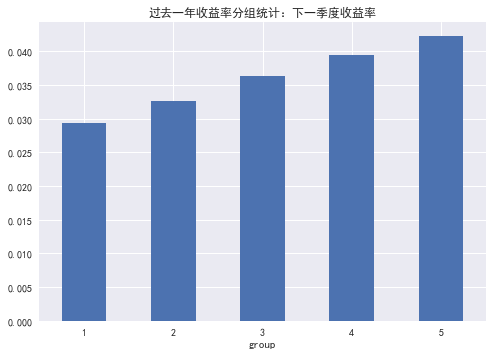

In [19]:
# 过去一年收益率对下一季度收益率有显著单调性
bar = group_stat['y_return'].plot.bar(rot=0, title='过去一年收益率分组统计：下一季度收益率')

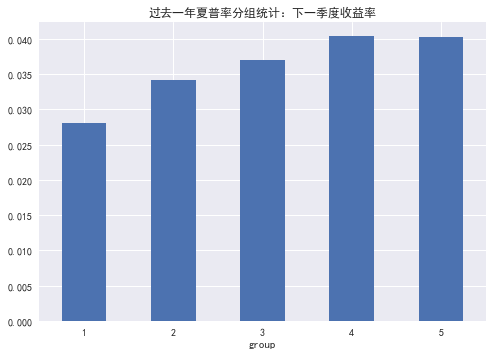

In [18]:
# 过去一年夏普率对下一季度收益率有较好的单调性
bar = group_stat['y_sharpe'].plot.bar(rot=0, title='过去一年夏普率分组统计：下一季度收益率')

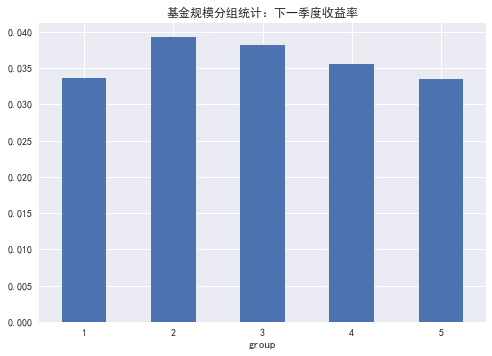

In [19]:
# 基金当季度规模对下一季度收益率分组呈现倒U性质，且表现最好的组为规模相对偏小的第2组
bar = group_stat['asset'].plot.bar(rot=0, title='基金规模分组统计：下一季度收益率')

### 基金筛选条件
+ asset 每一季度去掉大于100亿和小于1亿的
+ y_return 取第5组（前20%）
+ y_sharpe 取第5组（前20%）

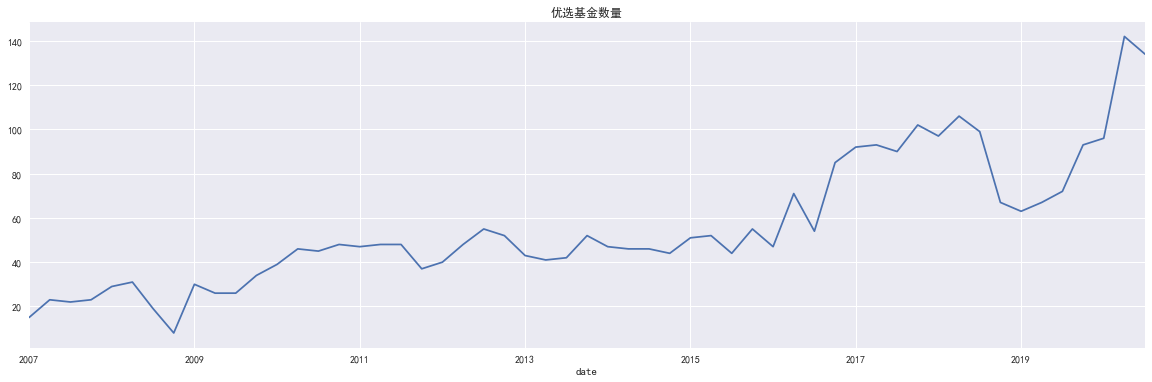

In [20]:
select_funds = funds_stat.query(
    "y_return_group in('5') & y_sharpe_group in('5') & asset>10e8 & asset<10e10")
# 优选基金池dict：key-Timestamp; value-fund codes list
funds_dict = select_funds.groupby('date')['code'].apply(lambda x: x.tolist()).to_dict()
funds_count = select_funds.groupby('date')['code'].apply(lambda x: x.count())
plot = funds_count.plot(title='优选基金数量', figsize=(20, 6))

计算优选基金的持续性

In [21]:
consistency = pd.DataFrame(columns=['consistency'])
last_codes = list(funds_dict.values())[0]
for date, codes in funds_dict.items():
    consistency.loc[date] = len(set(codes) & set(last_codes))/len(codes)
    last_codes = codes

优选基金持续性的平均比例为：0.5670


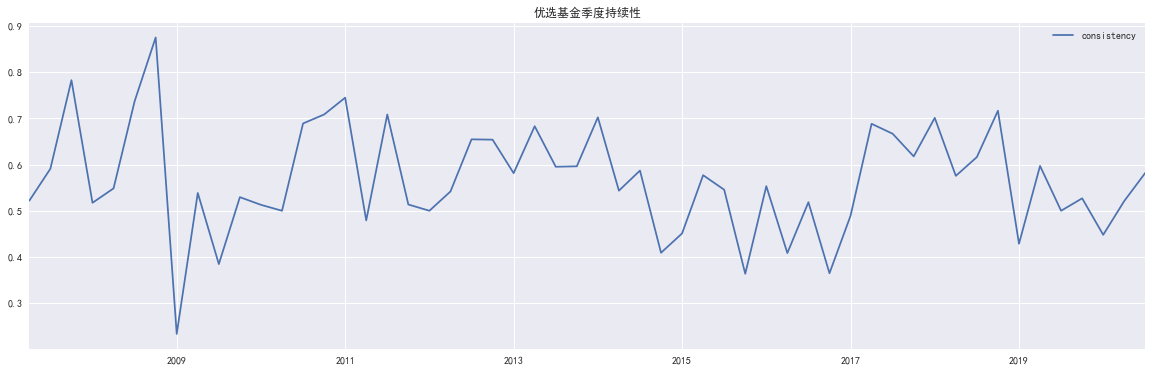

In [22]:
plot = consistency[1:].plot(title='优选基金季度持续性', figsize=(20,6))
print('优选基金持续性的平均比例为：{}'.format("%.4f" %(consistency[1:].mean()[0])))

整体而言优选基金的持续性稳定在50%-60%左右

### Step 3：基金季度重仓股票池

In [23]:
# 读取wind终端下载的基金持仓数据
def GetPortfolios(start_date, end_date, update=False):
    portfolios = pd.read_csv('funds_portfolio.csv', parse_dates=['date'])
    portfolios = portfolios[(portfolios['date'] >= start_date) & (portfolios['date'] <= end_date)]
    load_end_date = np.max(portfolios['date']).strftime('%Y%m%d')
    
    if (load_end_date < end_date) & update:
        # 需要有从wind终端下载的原始数据
        assert os.path.exists('portfolio'), 'portfolio file not exists'
        portfolio_files = os.listdir('portfolio')
        portfolios = []
        for file in tqdm(portfolio_files):
            portfolio = pd.read_excel('./portfolio/{}'.format(file))
            portfolio.dropna(subset=['股票代码'], inplace=True)
            portfolios.append(portfolio)
        portfolios = pd.concat(portfolios)
        portfolios.columns=['code', 'name', 'date', 'stock_code', 'stock_name', 'hold_amt', 'hold_amt_chg', 'hold_to_float', 'hold_mkv',
                            'hold_to_nav', 'hold_pct', 'type', 'manager']
        portfolios = portfolios.drop('hold_to_nav', axis=1)
        portfolios = portfolios[portfolios['type'].isin(['偏股混合型基金', '灵活配置型基金', '普通股票型基金'])]

        rpt_date = list(portfolios['date'].unique())
        date = list(pd.date_range('20030101', '20200930', freq='Q'))
        date = list(map(lambda x:x.strftime('%Y-%m-%d'), date))

        # 修改date为日期格式
        portfolios['date'] = portfolios['date'].replace(rpt_date, date)

        # 将hold_amt_chg的nan值填充为hold_amt(上一个季度若没有持仓，则该季度持仓变化为总持仓数)
        portfolios.loc[portfolios['hold_amt_chg'].isna(), 'hold_amt_chg'] = portfolios.loc[portfolios['hold_amt_chg'].isna(), 'hold_amt']
        portfolios.to_csv('funds_portfolio.csv', index=False)

    return portfolios

In [24]:
portfolios = GetPortfolios(start_date, end_date, update=update)

In [25]:
# 获取优选基金的持仓信息
portfolios = portfolios[portfolios['date'].isin(funds_dict.keys())]
def SelectFunds(df):
    date = df['date'].iloc[0]
    return df[df['code'].isin(funds_dict[date])]
portfolios = portfolios.groupby('date').apply(SelectFunds).reset_index(drop=True)

In [26]:
portfolios.head()

,code,name,date,stock_code,stock_name,hold_amt,hold_amt_chg,hold_to_float,hold_mkv,hold_pct,type,manager
0,000011.OF,华夏大盘精选,2007-03-31,000819.SZ,岳阳兴长,519.4234,201.7945,6.444387,11390.955162,3.928866,偏股混合型基金,华夏基金管理有限公司
1,000011.OF,华夏大盘精选,2007-03-31,600570.SH,恒生电子,524.9713,14.8163,4.784719,10000.703265,3.449353,偏股混合型基金,华夏基金管理有限公司
2,000011.OF,华夏大盘精选,2007-03-31,600028.SH,中国石化,1000.0000,1000.0000,0.279018,9930.000000,3.424966,偏股混合型基金,华夏基金管理有限公司
3,000011.OF,华夏大盘精选,2007-03-31,000960.SZ,锡业股份,500.0420,-189.0680,1.944852,9625.808500,3.320047,偏股混合型基金,华夏基金管理有限公司
4,000011.OF,华夏大盘精选,2007-03-31,000617.SZ,中油资本,512.6541,171.1792,5.348812,9586.631670,3.306535,偏股混合型基金,华夏基金管理有限公司


#### 行业分布的变化

In [27]:
stock_industry = pd.read_csv('stock_industry.csv', index_col=['date', 'stock_code'], parse_dates = ['date'])

In [28]:
sector_dict = {'金融':['房地产','非银金融','银行'],
               '消费':['传媒', '商业贸易', '纺织服装', '食品饮料', '休闲服务', '综合'],
               '制造':['机械设备','汽车','电气设备','计算机','通信','电子','轻工制造','家用电器'],
               '周期':['交通运输','化工','国防军工','建筑材料','建筑装饰','有色金属','钢铁','公用事业','采掘','农林牧渔'],
               '医药':['医药生物']}

In [29]:
# 添加行业和板块信息
def GetIndustry(series):
    date = series['date']
    stock_code = series['stock_code']
    if (date, stock_code) in stock_industry.index:
        industry = stock_industry.loc[(date, stock_code)]
    else:
        industry = None
    return industry

def GetSector(series):
    industry = series['industry']
    for k, v in sector_dict.items():
        if industry in v:
            sector = k
            break
    return sector
    
portfolios['industry'] = portfolios.apply(GetIndustry, axis=1)
portfolios = portfolios.dropna(subset = ['industry']).reset_index(drop=True)
portfolios['sector'] = portfolios.apply(GetSector, axis=1)

In [30]:
# 按日期和板块求和并计算持有板块市值的比例
sector_stat = portfolios[['date', 'hold_mkv', 'sector']].groupby(['date', 'sector'], as_index=False).sum()
sector_stat['hold_percent'] = sector_stat[['date','hold_mkv']].groupby('date').apply(lambda series: series/series.sum())

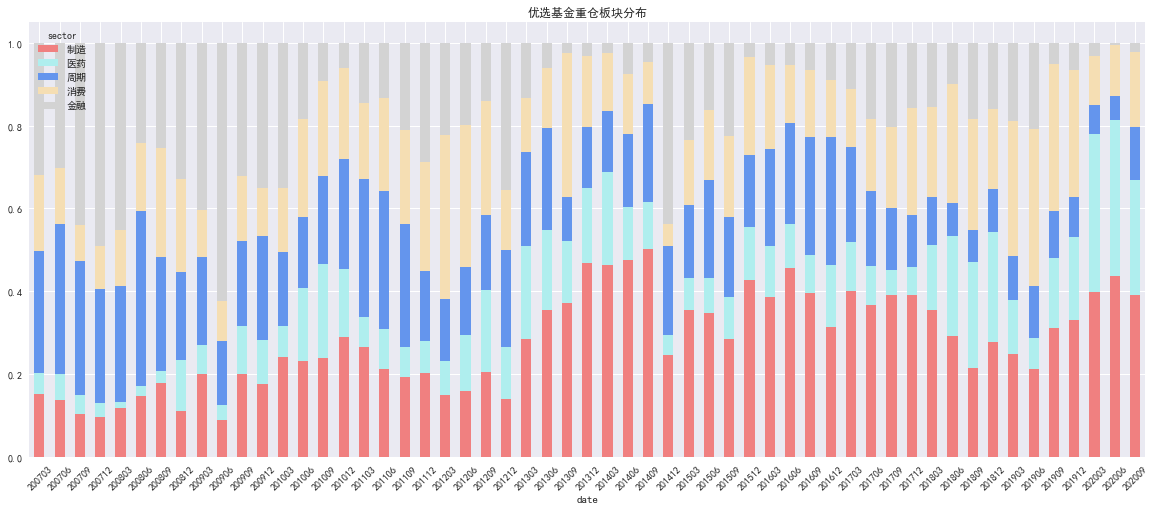

In [31]:
# 绘图
sector_pivot = sector_stat.pivot(index='date', columns='sector', values='hold_percent')
sector_pivot.index = sector_pivot.index.strftime('%Y%m%d').map(lambda x: x[:-2])

colors = ['#F08080', '#AFEEEE', '#6495ED', '#F5DEB3', '#D3D3D3']
plot = sector_pivot.plot.bar(stacked=True, figsize=(20,8), title='优选基金重仓板块分布', color=colors, rot=45)

In [32]:
# 统计每个季度基金持仓股票的集中程度：1 - 所有重仓股票数量/(基金数量*10)
stock_count = 1 - portfolios.groupby('date').apply(lambda df: len(df['stock_code'].unique())/(10*len(df['code'].unique())))

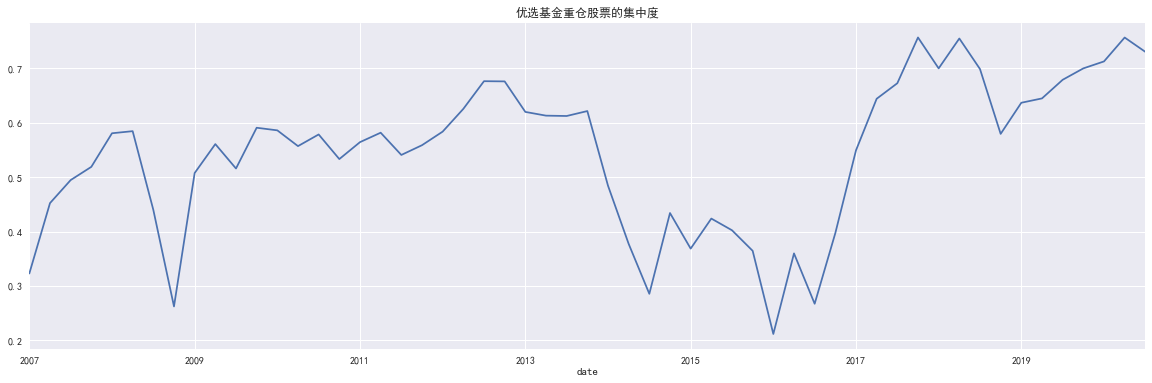

In [33]:
plot = stock_count.plot(title='优选基金重仓股票的集中度', figsize=(20,6))

可以看到，近年来基金重仓股票的集中度显著提升

### Step 4：计算因子值

In [34]:
portfolios.head(2)

,code,name,date,stock_code,stock_name,hold_amt,hold_amt_chg,hold_to_float,hold_mkv,hold_pct,type,manager,industry,sector
0,000011.OF,华夏大盘精选,2007-03-31,000819.SZ,岳阳兴长,519.4234,201.7945,6.444387,11390.955162,3.928866,偏股混合型基金,华夏基金管理有限公司,化工,周期
1,000011.OF,华夏大盘精选,2007-03-31,600570.SH,恒生电子,524.9713,14.8163,4.784719,10000.703265,3.449353,偏股混合型基金,华夏基金管理有限公司,计算机,制造


指标含义：
+ $hold\_amt$：持有股数
+ $hold\_amt\_chg$：持有股数变化
+ $hold\_to\_float$：持有股数占流通股比例
+ $hold\_mkv$：持有股票市值
+ $hold\_pct$：持有股票市值占该基金股票投资资金比例

**A. 机构配置偏好**

> $inv\_pct$：绝对配置比例 = 所有基金在该股票上持股市值/所有基金的全部股票持仓市值

In [35]:
portfolios['inv_pct'] = portfolios[['date', 'hold_mkv']].groupby('date').apply(
    lambda df: df['hold_mkv']/df['hold_mkv'].sum()).values

In [36]:
# 按日期和股票统计所有基金持有该股票市值占总投资资金的比例
hold_pct = portfolios[['date', 'stock_code', 'inv_pct']].groupby(['date', 'stock_code']).sum() * 100
hold_pct.columns = ['abs_inv_pct']
hold_pct.reset_index(inplace=True)

In [37]:
hold_pct.tail(2)

,date,stock_code,abs_inv_pct
11447,2020-09-30,688536.SH,0.015441
11448,2020-09-30,688567.SH,0.041453


> $excess\_inv\_pct$：超额配置比例 = 绝对配置比例 - 股票流通市值占全市场股票流通市值比例

In [38]:
stock_mkv = pd.read_csv('stock_mkv.csv', parse_dates=['date'])

In [39]:
# 计算股票在全市场流通市值中的比例
stock_mkv['mkv_pct'] = stock_mkv.groupby('date').apply(lambda df:df['mkv']/df['mkv'].sum()).values

# 计算基金超额配置比例
hold_pct = pd.merge(left=hold_pct, right=stock_mkv[['date', 'stock_code', 'mkv_pct']], on=['date', 'stock_code'], how='left')
hold_pct['excess_inv_pct'] = hold_pct['abs_inv_pct'] - hold_pct['mkv_pct'] * 100
hold_pct.drop(columns='mkv_pct', inplace=True)

In [40]:
hold_pct.tail(2)

,date,stock_code,abs_inv_pct,excess_inv_pct
11447,2020-09-30,688536.SH,0.015441,0.015209
11448,2020-09-30,688567.SH,0.041453,0.041136


>$fund\_pct$：持有某股票的基金数量占总基金数量的比例

In [41]:
q_funds_count = portfolios.groupby(['date']).apply(lambda df: len(df['code'].unique())).to_frame()
q_funds_count.columns = ['q_funds_count']

In [42]:
s_funds_count = portfolios.groupby(['date', 'stock_code'])['code'].count().to_frame()
s_funds_count.columns = ['s_funds_count']
funds_count = pd.merge(left=s_funds_count.reset_index(), right=q_funds_count, on='date' ,how='left')

In [43]:
funds_count['fund_pct'] = funds_count['s_funds_count']/funds_count['q_funds_count'] * 100
funds_count.drop(columns=['s_funds_count', 'q_funds_count'], inplace=True)
funds_count.tail(2)

,date,stock_code,fund_pct
11447,2020-09-30,688536.SH,0.8
11448,2020-09-30,688567.SH,0.8


**B. 机构话语权**

> $hold\_mkv$：基金在某股票上的投资总额

In [44]:
hold_mkv = portfolios.groupby(['date', 'stock_code'], as_index=False)['hold_mkv'].sum()
hold_mkv.tail(2)

,date,stock_code,hold_mkv
11447,2020-09-30,688536.SH,3479.80000
11448,2020-09-30,688567.SH,9341.96367


> $hold\_to\_float$：股本配置比例 = 基金配置的流通股数/全流通股数

In [45]:
share_pct = portfolios[['date', 'stock_code', 'hold_to_float']].groupby(['date', 'stock_code'], as_index=False).sum()
share_pct.tail(2)

,date,stock_code,hold_to_float
11447,2020-09-30,688536.SH,0.757640
11448,2020-09-30,688567.SH,2.468662


**因子整合及处理**

In [46]:
factors = pd.concat([hold_mkv.set_index(['date', 'stock_code']),
                     share_pct.set_index(['date', 'stock_code']),
                     funds_count.set_index(['date', 'stock_code']),
                     hold_pct.set_index(['date', 'stock_code'])], axis=1).reset_index()

In [47]:
factors.head()

,date,stock_code,hold_mkv,hold_to_float,fund_pct,abs_inv_pct,excess_inv_pct
0,2007-03-31,000002.SZ,54870.072915,1.016332,7.692308,2.694006,-26.268766
1,2007-03-31,000039.SZ,47934.532983,2.934510,15.384615,2.353485,-9.139847
2,2007-03-31,000060.SZ,33865.804350,3.173655,7.692308,1.662740,1.661915
3,2007-03-31,000061.SZ,6644.092735,1.446126,7.692308,0.326211,0.325902
4,2007-03-31,000069.SZ,5852.800000,0.602196,7.692308,0.287360,0.286353


In [48]:
# 生成因子的变化值
def GetFactorChg(factors, cols):
    factors_chg = []
    for col in cols:
        if col != 'excess_inv_pct':  
            pivot = factors.pivot(index='date', columns='stock_code', values=col).fillna(0)
        else:
            pivot = factors.pivot(index='date', columns='stock_code', values='abs_inv_pct').fillna(0)
            pivot_stock_mkv = stock_mkv.pivot(index='date', columns='stock_code', values='mkv_pct').fillna(0)
            pivot = pivot - pivot_stock_mkv.loc[:,pivot.columns]
            
        pivot_chg = pivot - pivot.shift(1)        
        pivot_chg = pivot_chg.stack().to_frame()
        pivot_chg.columns = [col+'_chg']
        factors_chg.append(pivot_chg)
    
    factors_chg = pd.concat(factors_chg, axis=1)
    return factors_chg.reset_index()

In [49]:
cols = ['hold_mkv', 'hold_to_float', 'fund_pct', 'abs_inv_pct', 'excess_inv_pct']
factors_chg = GetFactorChg(factors, cols)
factors = pd.merge(left=factors, right=factors_chg, on = ['date', 'stock_code'], how='left')

In [50]:
# 因子截面标准化+缩尾
def factor_processing(df):
    for col in df.columns:
        if col != 'stock_code':
            df[col] = (df[col] - np.mean(df[col]))/np.std(df[col])
            df[col] = df[col].map(lambda x: 3*np.sign(x) if np.abs(x) > 3 else x)
    return df

In [51]:
factors = factors.set_index('date').groupby('date').apply(factor_processing).reset_index()
factors.tail()

,date,stock_code,hold_mkv,hold_to_float,fund_pct,abs_inv_pct,excess_inv_pct,hold_mkv_chg,hold_to_float_chg,fund_pct_chg,abs_inv_pct_chg,excess_inv_pct_chg
11444,2020-09-30,688266.SH,-0.497276,-0.178266,-0.523547,-0.497276,-0.027266,0.079506,0.558255,0.129695,-0.021156,-0.020969
11445,2020-09-30,688363.SH,-0.462406,0.006680,-0.523547,-0.462406,-0.020267,0.012825,0.078256,-0.110465,-0.077263,-0.077072
11446,2020-09-30,688368.SH,-0.520686,0.237767,-0.523547,-0.520686,-0.032036,0.053228,0.894860,0.129695,-0.050446,-0.050260
11447,2020-09-30,688536.SH,-0.534447,-0.543516,-0.523547,-0.534447,-0.034922,0.037783,0.262738,0.129695,-0.067662,-0.067480
11448,2020-09-30,688567.SH,-0.485025,0.303136,-0.523547,-0.485025,-0.024768,0.093256,0.947749,0.129695,-0.005829,-0.005651


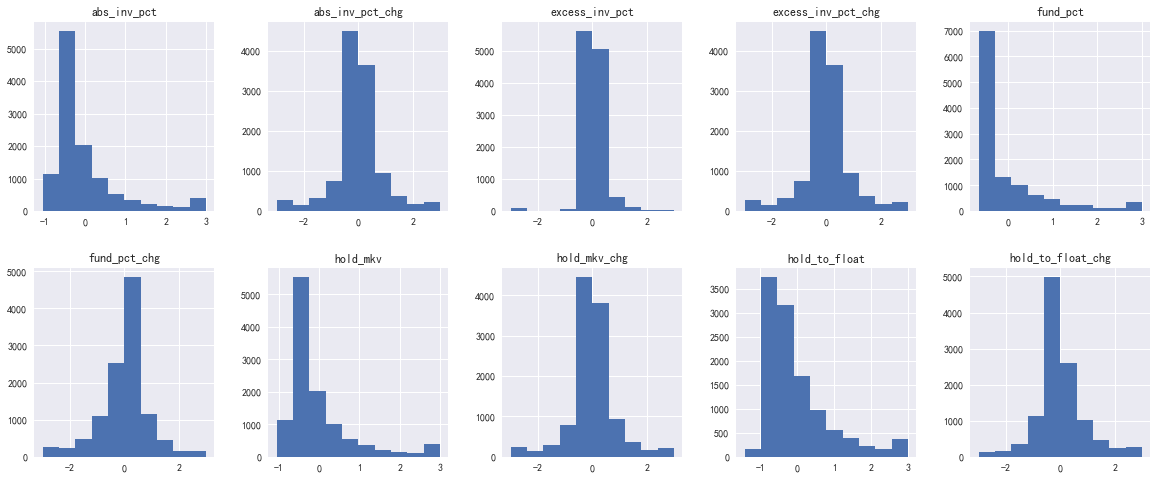

In [52]:
hist = factors.hist(figsize=(20,8), layout = (2,5))

In [53]:
# 股票代码和股票简称的字典
stock_name = pd.read_csv('stock_name.csv', index_col='stock_code')
stock_name = stock_name.to_dict()['name']

In [54]:
# 绘制表格查看每个综合因子得分前十的股票
def ViewTable(factors, by, top=10):

    def TopStocks(df, by, top=10):
        df = df.sort_values(by=by, ascending=False)
        top_stocks = pd.DataFrame()

        for i in range(top):
            top_stocks['rank_{}'.format(i+1)] = [df['stock_code'].iloc[i]]
        return top_stocks
    
    table = factors.groupby('date').apply(TopStocks, by=by, top=top)
    table.index = table.index.levels[0]
    table = table.applymap(lambda x: stock_name[x])

    return table.sort_index(ascending=False)

In [55]:
ViewTable(factors, by='hold_mkv_chg', top=10).head()

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
date,,,,,,,,,,
2020-09-30,隆基股份,贵州茅台,五粮液,通威股份,顺丰控股,京东方A,中国中免,伊利股份,美的集团,智飞生物
2020-06-30,药明康德,圣邦股份,长春高新,恒瑞医药,立讯精密,隆基股份,兆易创新,恒生电子,金山办公,宁德时代
2020-03-31,迈瑞医疗,康泰生物,乐普医疗,健帆生物,浪潮信息,恒生电子,中公教育,恒瑞医药,用友网络,绝味食品
2019-12-31,康泰生物,长春高新,三一重工,万科A,恒瑞医药,立讯精密,古井贡酒,亿纬锂能,中兴通讯,格力电器
2019-09-30,药明康德,立讯精密,恒瑞医药,华兰生物,海康威视,长春高新,顺鑫农业,金域医学,海大集团,汇顶科技


In [56]:
factors['industry'] = factors.apply(lambda series: stock_industry.loc[(series['date'], series['stock_code'])], axis=1)

### Step 5：策略回测

得多每季度投资的股票及权重

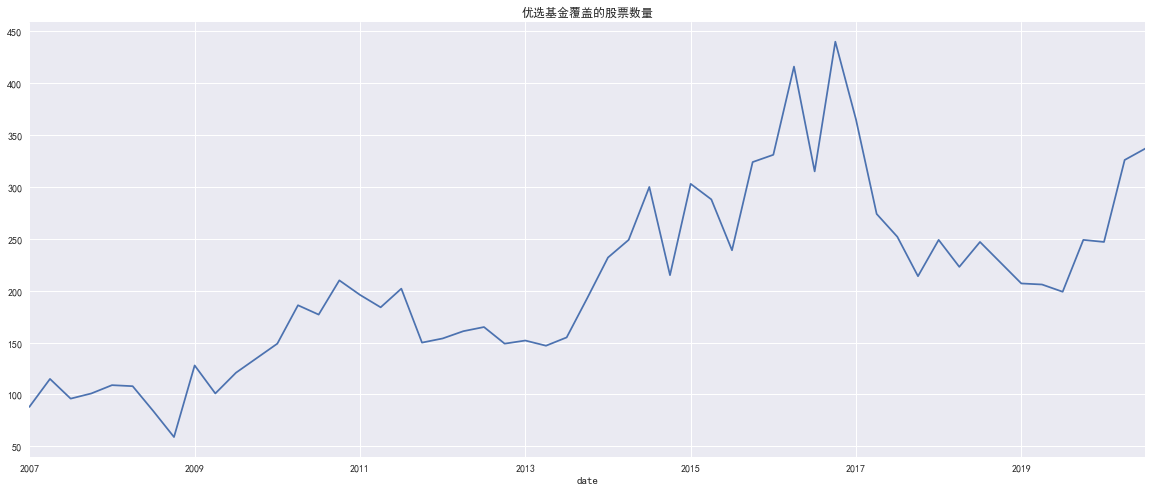

In [57]:
# 每个季度优选基金覆盖的股票数量
plot = factors.groupby('date')['stock_code'].count().plot(figsize=(20,8), title='优选基金覆盖的股票数量')

In [58]:
# 选取每个季度得分前top的股票
def SelectStocks(factors, by, fac_weights=None, top=20):
    if not fac_weights: 
        fac_weights = [1/top for i in range(len(by))]
    fac_weights = np.array(fac_weights).reshape(1,-1)
    fac = factors.copy()
    fac['score'] = fac[by].apply(lambda row: row.fillna(0).dot(fac_weights.T)[0], axis=1)
    
    # 根据因子得分选股 限制单一行业最大配置比例为limit
    def control_industry(df, top, limit_pct=0.1):
        limit = top*limit_pct
        ind_count = {}
        index = []
        df = df.sort_values(by='score', ascending=False)[['stock_code', 'score', 'industry']]
        for i in range(len(df)):
            ind = df['industry'].iloc[i]
            if ind not in ind_count.keys():
                ind_count[ind] = 0
            else:
                ind_count[ind] += 1
            
            if ind_count[ind] <= limit:
                index.append(i)
            
            if len(index) == top:
                break
            
        return df[['stock_code', 'score']].iloc[index]
        
    select_stocks = fac.groupby('date').apply(control_industry, top=top)
    select_stocks = select_stocks.reset_index().drop(columns='level_1')
    select_stocks['score'] = select_stocks['score'].map(lambda x: 0 if x<0 else x)
    select_stocks['score_weight'] = select_stocks.groupby('date')['score'].apply(lambda series: series/series.sum())
    select_stocks['avg_weight'] = 1/top
    
    return select_stocks

In [59]:
# 构建的因子列表
[col for col in factors.columns if col not in ['date', 'stock_code', 'industry']]

['hold_mkv',
 'hold_to_float',
 'fund_pct',
 'abs_inv_pct',
 'excess_inv_pct',
 'hold_mkv_chg',
 'hold_to_float_chg',
 'fund_pct_chg',
 'abs_inv_pct_chg',
 'excess_inv_pct_chg']

In [60]:
# 基于构建的因子选股举例
select_stocks = SelectStocks(factors, by=['fund_pct', 'hold_to_float_chg'], top=20)
select_stocks.tail()

,date,stock_code,score,score_weight,avg_weight
1095,2020-09-30,300760.SZ,0.115434,0.042988,0.05
1096,2020-09-30,688188.SH,0.114867,0.042777,0.05
1097,2020-09-30,300037.SZ,0.097693,0.036381,0.05
1098,2020-09-30,300035.SZ,0.095892,0.035711,0.05
1099,2020-09-30,002027.SZ,0.093674,0.034885,0.05


计算策略净值

In [61]:
stock_return = pd.read_csv('stock_return.csv',parse_dates = ['date'], index_col='date')
stock_return = stock_return/100

In [62]:
def GetNav(stock_return, select_stocks, weights='avg_weight'):
    
    # 基金季报在每个季度结束后15个交易日内披露 获取季度日期和交易日期的对应关系
    dates = stock_return.index.tolist()
    q_dates = select_stocks['date'].unique()

    rebalance_dates=[]
    for i in range(len(q_dates)):
        dates_after = [d for d in dates if d > q_dates[i]]
        rebalance_index = dates.index(dates_after[0]) + 15
        if (rebalance_index > (len(dates)-1)):
            break
        else:
            rebalance_date = dates[rebalance_index]
            rebalance_dates.append(rebalance_date)
        
    # key: rebalance_date, value: quarter_end_date
    date_map = dict(zip(rebalance_dates, q_dates[:len(rebalance_dates)]))
    
    strategy_nav = pd.DataFrame(columns=['nav'], index=stock_return.index)  

    last_nav = 1 # rebalance_date前一天的策略净值
    for i in range(len(rebalance_dates)):
        start_date = rebalance_dates[i]

        if i < (len(rebalance_dates)-1):
            end_date = rebalance_dates[i+1]
            date_range = [d for d in dates if (d>=start_date) and (d<end_date)]
        else:
            date_range = [d for d in dates if d>=start_date]

        q_date = date_map[start_date]
        stocks = select_stocks.loc[select_stocks['date'] == q_date, 'stock_code']
        weight = select_stocks.loc[select_stocks['date'] == q_date, weights].fillna(0)
        daily_return = stock_return.loc[date_range, stocks].dot(np.array(weight).reshape(-1,1))
        daily_nav = (daily_return+1).cumprod()
        cum_daily_nav = daily_nav*last_nav
        last_nav = cum_daily_nav.iloc[-1]

        strategy_nav.loc[date_range] = cum_daily_nav
    return strategy_nav

In [63]:
# 选取hold_to_float_chg和fund_pct_chg两个因子等权构建策略
cols = ['hold_to_float_chg', 'fund_pct_chg']
fac_weights=[0.5, 0.5]

select_stocks = SelectStocks(factors, by=cols, fac_weights=fac_weights, top=20)
strategy_nav = GetNav(stock_return, select_stocks, weights='avg_weight')
strategy_nav = strategy_nav.fillna(1)
strategy_nav.columns = ['strategy_nav']

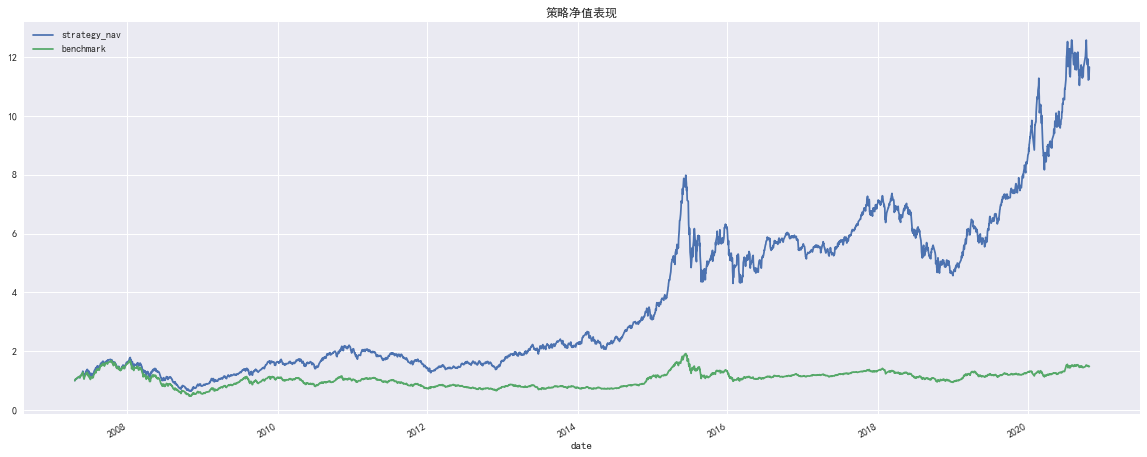

In [64]:
# 读取benchmark 中证800
benchmark = pd.read_csv('benchmark.csv', index_col='date', parse_dates=['date'])
benchmark.columns = ['benchmark']

nav_start_date = strategy_nav[strategy_nav['strategy_nav'] == 1].index[-1]
strategy_nav = strategy_nav.loc[nav_start_date:]
nav_df = pd.concat([strategy_nav, benchmark], axis=1,join='inner').dropna()

nav_df['benchmark'] = nav_df['benchmark'] / nav_df['benchmark'].iloc[0]

plot = nav_df.plot(figsize=(20,8), title='策略净值表现')

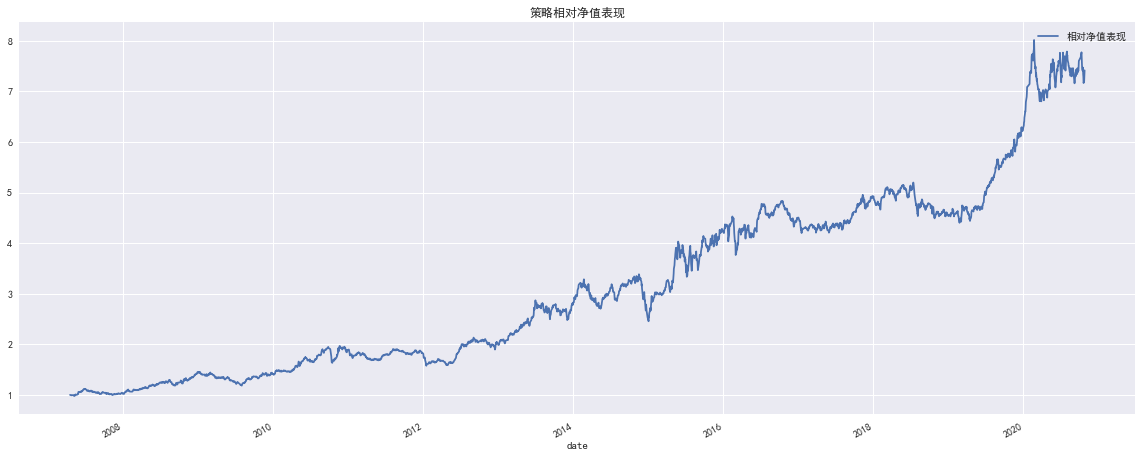

In [65]:
relative_return = (nav_df['strategy_nav'].pct_change().fillna(0) - nav_df['benchmark'].pct_change().fillna(0)).to_frame()
relative_nav = (relative_return+1).cumprod()
relative_nav.columns = ['相对净值表现']
plot = relative_nav.plot(figsize=(20,8), title='策略相对净值表现')

计算策略表现

In [66]:
# 计算组合收益率分析:年化收益率、收益波动率、夏普比率、最大回撤
def strategy_performance(nav_df):
    
    return_df = nav_df.pct_change().dropna()  # 在计算净值变化率时，首日得到的是缺失值，需将其删除
    analyze = pd.DataFrame(columns = ['start_date', 'end_date', 'annual_return', 'return_volatility',
                                     'sharpe_ratio'], index= nav_df.columns)  # 用于存储计算的指标
    
    analyze['start_date'].iloc[0] = nav_df.index[0].strftime('%Y-%m-%d')
    analyze['end_date'].iloc[0] = nav_df.index[-1].strftime('%Y-%m-%d')
    
    # 计算年化收益率
    cum_nav = np.exp(np.log1p(return_df).cumsum())
    cum_return = cum_nav-1
    annual_return = (1+cum_return.iloc[-1])**(252/len(return_df))-1  # 计算年化收益率
    analyze['annual_return'] = annual_return

    # 计算收益波动率（以年为基准）
    analyze['return_volatility'] = return_df.std()*np.sqrt(252)

    # 计算夏普比率
    risk_free = 0.00
    return_risk_adj = return_df-risk_free
    analyze['sharpe_ratio'] = return_risk_adj.mean() / np.std(return_risk_adj, ddof=1)

    # 计算最大回撤
    max_nav = cum_nav.cummax()  # 计算累计收益率的在各个时间段的最大值
    analyze['max_drawdown'] = cum_nav.sub(max_nav).div(max_nav).min()  
    
    return analyze.T

def get_return_year(nav_df):

    result_dic = {}
    for y, df in nav_df.groupby(pd.Grouper(level='date', freq='Y')):
        result = strategy_performance(df)
        result_dic[y.strftime('%Y')] = result

    result_df = pd.concat(result_dic.values(), axis=1)
    result_df.columns = result_dic.keys()
    return result_df.T

In [67]:
pd.concat([strategy_performance(strategy_nav),strategy_performance(relative_nav)], axis=1)

,strategy_nav,相对净值表现
start_date,2007-04-20,2007-04-20
end_date,2020-10-28,2020-10-28
annual_return,0.207123,0.165967
return_volatility,0.307018,0.158554
sharpe_ratio,0.0483546,0.0660237
max_drawdown,-0.637219,-0.274536


In [68]:
get_return_year(strategy_nav)

,start_date,end_date,annual_return,return_volatility,sharpe_ratio,max_drawdown
2007,2007-04-20,2007-12-28,1.05162,0.372733,0.133419,-0.213124
2008,2008-01-02,2008-12-31,-0.509992,0.455451,-0.0842489,-0.637219
2009,2009-01-05,2009-12-31,0.99811,0.297908,0.155975,-0.163635
2010,2010-01-04,2010-12-31,0.264575,0.27558,0.0623517,-0.189407
2011,2011-01-04,2011-12-30,-0.314519,0.23245,-0.0949459,-0.320351
2012,2012-01-04,2012-12-31,0.216006,0.23833,0.0591804,-0.171319
2013,2013-01-04,2013-12-31,0.404722,0.274148,0.0867585,-0.144153
2014,2014-01-02,2014-12-31,0.372541,0.243378,0.0897065,-0.22536
2015,2015-01-05,2015-12-31,1.03123,0.418831,0.119962,-0.454215
2016,2016-01-04,2016-12-30,-0.0149678,0.339525,0.00799947,-0.25187


### Step 6：研究结果总结

>总体而言，基于公募基金持仓数据能够获取表现不错的超额年化收益。07年至今年化收益约20%，相较中证800的超额年化收益约16%。

>通过上表可以看到在07,09,13,14,15,17,19和20年该策略均取得了30%以上的收益表现，但在08,11和18年产生了大于30%的跌幅。通过策略整体的夏普率和最大回撤等表现也可以看出，仅仅基于公募持仓数据构建的因子策略在时间序列上的表现不太稳定。

>后续的优化空间：在获取优选基金的股票持仓池后，除了使用基金持仓数据本身构建的因子外，可以加入其它如成长、分析师预期、价量、另类数据等多维度因子，提高策略的稳健性（减小波动和回撤）和灵活性（提高调仓频率）。

_参考报告：_

1. 国信证券：基于优秀基金持仓的业绩增强策略 2020.11.15
2. 华安证券：透视机构抱团行为，量化视角全面解析——基金研究系列之一 2020.09.29
3. 国盛证券：多因子系列之十三：基金重仓股研究 2020.09.07
4. 海通证券：选股因子系列研究（六十八）——基金重仓超配因子及其对指数增强组合的影响 2020.07.07